In [ ]:
!pip install -r /content/requirements.txt

In [ ]:
!git clone https://github.com/IDEA-Research/GroundingDINO.git

In [ ]:
!pip install -e /content/GroundingDINO

# In-Painting

In [ ]:
# !python /content/download_files.py

In [59]:
import sys
sys.path.append(r"C:\Users\sumuk\OneDrive\Desktop\GitHub\FashionXchange")

In [60]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from segment_anything import SamPredictor, sam_model_registry
from diffusers import StableDiffusionInpaintPipeline
from groundingdino.util.inference import load_model, load_image, predict, annotate
from GroundingDINO.groundingdino.util import box_ops
import argparse

In [61]:
def show_mask(mask, image, random_color=True):
    """
    Overlay a mask on an image and return the composited result.

    Args:
        mask (torch.Tensor): Mask to overlay.
        image (np.ndarray): Image to overlay the mask on.
        random_color (bool, optional): If True, overlay with random color.
                                      If False, use a fixed color. Default is True.

    Returns:
        np.ndarray: Image with the mask overlaid.
    """
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])

    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

def transform_boxes(predictor,boxes, src,device):
    """
    Transform boxes to adjust to the source image dimensions.

    Args:
        boxes (torch.Tensor): Bounding boxes in the format [x_center, y_center, width, height].
        src (np.ndarray): Source image.

    Returns:
        torch.Tensor: Transformed boxes.
    """
    H, W, _ = src.shape
    boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])
    return predictor.transform.apply_boxes_torch(boxes_xyxy, src.shape[:2]).to(device)

def save_image(image, file_path):
    """
    Save an image to the specified file path.

    Args:
        image (PIL.Image.Image): Image to be saved.
        file_path (str): Path where the image will be saved.
    """
    try:
        image.save(file_path)
        print(f"Image saved: {file_path}")
    except Exception as e:
        print(f"Error saving image to {file_path}: {e}")

In [62]:
def edit_image(path, item, prompt, box_threshold, text_threshold):
    """
    Edit an image by replacing objects using segmentation and inpainting.

    Args:
        path (str): Path to the image file.
        item (str): Object to be recognized in the image.
        prompt (str): Object to replace the selected object in the image.
        box_threshold (float): Threshold for bounding box predictions.
        text_threshold (float): Threshold for text predictions.

    Returns:
        np.ndarray: Edited image.
    """
    src, img = load_image(path)

    # Predict object bounding boxes, logits, and phrases
    boxes, logits, phrases = predict(
        model=groundingdino_model,
        image=img,
        caption=item,
        box_threshold=box_threshold,
        text_threshold=text_threshold
    )

    # Set up predictor
    sam_predictor.set_image(src)
    new_boxes = transform_boxes(sam_predictor,boxes, src,device)

    # Predict masks and annotations
    masks, _, _ = sam_predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=new_boxes,
        multimask_output=False,
    )

    # Overlay mask on annotated image
    img_annotated_mask = show_mask(
        masks[0][0].cpu(),
        annotate(image_source=src, boxes=boxes, logits=logits, phrases=phrases)[...,::-1]
    )

    # Apply inpainting pipeline
    edited_image = pipeline(prompt=prompt,
                        image=Image.fromarray(src).resize((512, 512)),
                        mask_image=Image.fromarray(masks[0][0].cpu().numpy()).resize((512, 512))
    ).images[0]

    return edited_image

In [68]:
device = "cuda"

# Paths
sam_checkpoint_path = r"C:\Users\sumuk\OneDrive\Desktop\GitHub\FashionXchange\GroundingDINO\weights\sam_vit_h_4b8939.pth"
groundingdino_model_path = r"C:\Users\sumuk\OneDrive\Desktop\GitHub\FashionXchange\GroundingDINO\groundingdino\config\GroundingDINO_SwinT_OGC.py"
groundingdino_weights_path = r"C:\Users\sumuk\OneDrive\Desktop\GitHub\FashionXchange\GroundingDINO\weights\groundingdino_swint_ogc.pth" 

# SAM Parameters
model_type = "vit_h"
sam_model = sam_model_registry[model_type](checkpoint=sam_checkpoint_path).to(device=device)
sam_predictor = SamPredictor(sam_model)

# # Stable Diffusion
# pipeline = StableDiffusionInpaintPipeline.from_pretrained("stabilityai/stable-diffusion-2-inpainting",
#                                                      torch_dtype=torch.float16).to(device)

# Grounding DINO
groundingdino_model = load_model(groundingdino_model_path, groundingdino_weights_path)

c:\Users\sumuk\anaconda3\envs\FashionXchange\lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


In [69]:
def get_mask(img_path, looking_for, box_threshold=0.3, text_threshold=0.25):
  fig, axs = plt.subplots(1, 3, figsize=(12, 4))
  src, img = load_image(img_path)
  axs[0].imshow(src, cmap='gray')
  axs[0].set_title('Source Image')
  axs[0].axis('off')
  boxes, logits, phrases = predict(
        model=groundingdino_model,
        image=img,
        caption=looking_for,
        box_threshold=box_threshold,
        text_threshold=text_threshold
    )
  annotated_frame = annotate(image_source=src, boxes=boxes, logits=logits, phrases=phrases)
  axs[1].imshow(np.flip(annotated_frame, 2), cmap='gray')
  axs[1].set_title('DINO o/p')
  axs[1].axis('off')

  sam_predictor.set_image(src)
  new_boxes = transform_boxes(sam_predictor,boxes, src, device)
  masks, _, _ = sam_predictor.predict_torch(
      point_coords=None,
      point_labels=None,
      boxes=new_boxes,
      multimask_output=False,
  )
  masks = torch.any(masks, dim=0, keepdim=True)
  img_annotated_mask = show_mask(
        masks[0][0].cpu(),
        annotate(image_source=src, boxes=boxes, logits=logits, phrases=phrases)[...,::-1]
    )
  axs[2].imshow(img_annotated_mask, cmap='gray')
  axs[2].set_title('SAM o/p')
  axs[2].axis('off')
  return masks, src

## Natural background image

KeyboardInterrupt: 

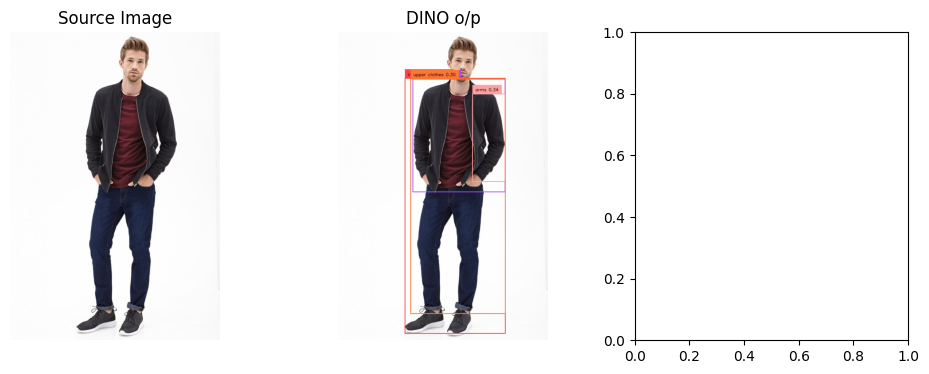

In [71]:
image_path = r"C:\Users\sumuk\OneDrive\Desktop\GitHub\FashionXchange\text2human\images\MEN-Denim-id_00000750-01_1_front.jpg"
looking_for = "upper clothes, arms"
masks, src = get_mask(image_path, looking_for, box_threshold=0.3, text_threshold=0.25)

In [ ]:
change_required = "A lady standing sideways wearing a Women's suit"

In [ ]:
edited_image = pipeline(prompt=change_required,
                        image=Image.fromarray(src).resize((512, 512)),
                        mask_image=Image.fromarray(masks[0][0].cpu().numpy()).resize((512, 512))
    ).images[0]
plt.imshow(edited_image)

In [ ]:
image_path = "/content/MEN-Denim-id_00000089-02_7_additional.jpg"
looking_for = "clothes, arms"
masks, src = get_mask(image_path, looking_for, box_threshold=0.3, text_threshold=0.25)

In [ ]:
change_required = "A guy sitting while wearing a Man's half sleeve sweater and shorts"

In [ ]:
edited_image = pipeline(prompt=change_required,
                        image=Image.fromarray(src).resize((512, 512)),
                        mask_image=Image.fromarray(masks[0][0].cpu().numpy()).resize((512, 512))
    ).images[0]
plt.imshow(edited_image)

In [ ]:
image_path = "//content/MEN-Jackets_Vests-id_00002173-04_4_full.jpg"
looking_for = "clothes, arms"
masks, src = get_mask(image_path, looking_for, box_threshold=0.3, text_threshold=0.25)

In [ ]:
change_required = "A guy wearing a Man's half sleeve sweater and shorts with watch"

In [ ]:
edited_image = pipeline(prompt=change_required,
                        image=Image.fromarray(src).resize((512, 512)),
                        mask_image=Image.fromarray(masks[0][0].cpu().numpy()).resize((512, 512))
    ).images[0]
plt.imshow(edited_image)

# Image Generation

In [ ]:
# !pip install xformers

In [56]:
import torch
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
# import xformers

c:\Users\sumuk\anaconda3\envs\FashionXchange\lib\site-packages\diffusers\utils\outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [ ]:
# !export XFORMERS_BACKENDS=torch

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    use_safetensors=True,
).to("cuda")

In [ ]:
prompt = "High resolution photo of a guy's face"
pipe.enable_attention_slicing()
image = pipe(prompt).images[0]

In [ ]:
plt.imshow(image)

# Mask perturbation

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
def perturb_mask(mask):
    ones = np.where(mask == True)
    y_max, y_min, x_max, x_min = max(ones[0]), min(ones[0]), max(ones[1]), min(ones[1])
    increase_or_decrease = [0, 1]
    up_down_left_right = [0, 1, 2, 3]
    choice_increase_or_decrease = np.random.choice(increase_or_decrease)
    choice_udlr = np.random.choice(up_down_left_right)
    if choice_udlr == 0 or choice_udlr == 1:
        increase_or_decrease_quantity = np.random.randint(50, (y_max - y_min) // 5)
    elif choice_udlr == 2 or choice_udlr == 3:
        increase_or_decrease_quantity = np.random.randint(50, (x_max - x_min) // 4)
    print(choice_udlr, choice_increase_or_decrease, increase_or_decrease_quantity)
    if choice_increase_or_decrease == 0:
        if choice_udlr == 0:
            increase_or_decrease_quantity = min(increase_or_decrease_quantity, y_min)
            mask[y_min - increase_or_decrease_quantity: y_min + (y_max - y_min) // 6, x_min: x_max + 1] = True
        elif choice_udlr == 1:
            increase_or_decrease_quantity = min(increase_or_decrease_quantity, mask.shape[0] - y_max)
            mask[y_max - (y_max - y_min) // 6: y_max + increase_or_decrease_quantity, x_min: x_max + 1] = True
        elif choice_udlr == 2:
            increase_or_decrease_quantity = min(x_min, increase_or_decrease_quantity)
            mask[y_min: y_max + 1, x_min - increase_or_decrease_quantity: x_min + (x_max - x_min) // 4] = True
        else:
            increase_or_decrease_quantity = min(mask.shape[1] - x_max, increase_or_decrease_quantity)
            mask[y_min: y_max + 1, x_max - (x_max - x_min) // 4: x_max + increase_or_decrease_quantity] = True
    elif choice_increase_or_decrease == 1:
        if choice_udlr == 0:
            mask[y_min: y_min + increase_or_decrease_quantity, x_min: x_max + 1] = False
        elif choice_udlr == 1:
            mask[y_max: y_max - increase_or_decrease_quantity, x_min: x_max + 1] = False
        elif choice_udlr == 2:
            mask[y_min: y_max + 1, x_min: x_min + increase_or_decrease_quantity] = False
        else:
            mask[y_min: y_max + 1, x_max - increase_or_decrease_quantity: x_max] = False
    return mask

In [ ]:
mask_path = r"C:\Users\sumuk\Downloads\content_mask.npy"
image_path = r"C:\Users\sumuk\Downloads\MEN-Denim-id_00000089-01_7_additional.jpg"
mask = np.load(mask_path)
image = np.array(Image.open(image_path))
plt.imshow(mask)

In [ ]:
perturbed_mask = perturb_mask(mask)
plt.imshow(perturbed_mask)

In [ ]:
image = torch.from_numpy(image).to(dtype=torch.float32) / 127.5 - 1.0
perturbed_mask = torch.from_numpy(perturbed_mask)
perturbed_mask = perturbed_mask.unsqueeze(-1).expand(-1, -1, 3)
masked_image = image * (perturbed_mask < 0.5)
plt.imshow(masked_image)

In [ ]:
plt.imshow(image)

# Targetted Mask Dataset testing

In [1]:
import os
from PIL import Image
import numpy as np
import torch
import json
from glob import glob
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import transforms
from transformers import CLIPTokenizer

c:\Users\sumuk\anaconda3\envs\FashionXchange\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def text_file_reader(file_path):
    """
    Read the contents of a text file.
    Args:
        file_path (str): The path to the text file.
    Returns:
        list: A list containing the lines of text from the file.
    """
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
        return lines
    
    except FileNotFoundError:
        print(f"File '{file_path}' not found.")
        return None
    except Exception as e:
        print(f"Error reading file: {e}")
        return None

In [3]:
tokenizer = CLIPTokenizer.from_pretrained("stabilityai/stable-diffusion-2-inpainting", subfolder="tokenizer")

In [38]:
class TargetedMaskingDataset(Dataset):
    def __init__(self, 
                instance_image_captions_file, 
                instance_image_dir,
                instance_images_mask_dir, 
                tokenizer,
                image_size=512):
        self.tokenizer = tokenizer
        self.instance_image_captions = self.caption_file_reader(instance_image_captions_file)
        self.mask_directory = instance_images_mask_dir
        self.instance_image_list = [os.path.join(instance_image_dir, image_file) for image_file in self.instance_image_captions.keys()]
        self.image_transforms_resize = transforms.Compose(
            [
                transforms.Resize((image_size, image_size), interpolation=transforms.InterpolationMode.BILINEAR),
                # transforms.CenterCrop(image_size)
            ]
        )
        self.image_transforms_resize2 = transforms.Compose(
            [
                transforms.Resize((image_size, image_size), interpolation=transforms.InterpolationMode.NEAREST),
                # transforms.CenterCrop(image_size)
            ]
        )
        self.image_transforms = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return len(self.instance_image_captions)

    @staticmethod
    def caption_file_reader(captions_file_path, image_directory=None):
        ext = os.path.splitext(captions_file_path)[1]
        if captions_file_path.endswith(".txt"):
            assert image_directory is not None
            captions = text_file_reader(captions_file_path)
            image_vs_captions = dict()
            img_list = glob(os.path.join(image_directory, '*.jpg'))
            for img_path, caption in zip(img_list, captions):
                img_name = os.path.basename(img_path)
                image_vs_captions[img_name] = caption
            return image_vs_captions
        elif captions_file_path.endswith(".json"):
            """
            Code for creating a dictionary of image_name vs captions by reading a json file 
            """
            with open(captions_file_path, "r") as json_file:
                image_vs_captions = json.load(json_file)
            return image_vs_captions

        elif captions_file_path.endswith(".yaml"):
            """
            Code for creating a dictionary of image_name vs captions by reading a yaml file 
            """
            pass
    
    def __getitem__(self, idx):
        example = dict()
        image_name = os.path.basename(self.instance_image_list[idx])
        instance_image = Image.open(self.instance_image_list[idx] + ".jpg")
        mask_paths = os.listdir(os.path.join(self.mask_directory, image_name))
        if not instance_image.mode == "RGB":
            instance_image = instance_image.convert("RGB")
        random_selector = np.random.randint(0, len(mask_paths))
        # print(mask_paths[random_selector])
        selected_mask = Image.open(os.path.join(self.mask_directory, os.path.join(image_name, mask_paths[random_selector])))
        example["mask"] = self.image_transforms_resize2(selected_mask)
        instance_image = self.image_transforms_resize(instance_image)
        example["PIL_image"] = instance_image
        example["instance_image"] = self.image_transforms(instance_image)
        example["instance_prompt_ids"] = self.tokenizer(
            self.instance_image_captions[image_name],
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids
        return example
    

def random_perturb_mask(mask):
    ones = np.where(mask > 0)
    y_max, y_min, x_max, x_min = max(ones[0]), min(ones[0]), max(ones[1]), min(ones[1])
    increase_or_decrease = [0, 1]
    up_down_left_right = [0, 1, 2, 3]
    choice_increase_or_decrease = np.random.choice(increase_or_decrease)
    choice_udlr = np.random.choice(up_down_left_right)
    if choice_udlr == 0 or choice_udlr == 1:
        increase_or_decrease_quantity = np.random.randint(50, 100)
    elif choice_udlr == 2 or choice_udlr == 3:
        increase_or_decrease_quantity = np.random.randint(50, 100)
    # print(choice_increase_or_decrease, choice_udlr, increase_or_decrease_quantity)
    if choice_increase_or_decrease == 0:
        if choice_udlr == 0:
            increase_or_decrease_quantity = min(increase_or_decrease_quantity, y_min)
            mask[y_min - increase_or_decrease_quantity: y_min + (y_max - y_min) // 6, x_min: x_max + 1] = True
        elif choice_udlr == 1:
            increase_or_decrease_quantity = min(increase_or_decrease_quantity, mask.shape[0] - y_max)
            mask[y_max - (y_max - y_min) // 6: y_max + increase_or_decrease_quantity, x_min: x_max + 1] = True
        elif choice_udlr == 2:
            increase_or_decrease_quantity = min(x_min, increase_or_decrease_quantity)
            mask[y_min: y_max + 1, x_min - increase_or_decrease_quantity: x_min + (x_max - x_min) // 4] = True
        else:
            increase_or_decrease_quantity = min(mask.shape[1] - x_max, increase_or_decrease_quantity)
            mask[y_min: y_max + 1, x_max - (x_max - x_min) // 4: x_max + increase_or_decrease_quantity] = True
    elif choice_increase_or_decrease == 1:
        if choice_udlr == 0:
            mask[y_min: y_min + increase_or_decrease_quantity, x_min: x_max + 1] = False
        elif choice_udlr == 1:
            mask[y_max: y_max - increase_or_decrease_quantity, x_min: x_max + 1] = False
        elif choice_udlr == 2:
            mask[y_min: y_max + 1, x_min: x_min + increase_or_decrease_quantity] = False
        else:
            mask[y_min: y_max + 1, x_max - increase_or_decrease_quantity: x_max] = False
    return mask            


def collate_fn(examples):
    input_ids = [example["instance_prompt_ids"] for example in examples]
    pixel_values = [example["instance_image"] for example in examples]
    masks = []
    masks_og = []
    masked_images = []
    for example in examples:
        pil_image = np.array(example["PIL_image"])
        mask_og = np.array(example["mask"])
        mask = random_perturb_mask(mask_og)
        image = torch.from_numpy(pil_image).to(dtype=torch.float32) / 127.5 - 1.0
        mask = torch.from_numpy(mask)
        mask = mask.unsqueeze(2)
        masked_image = image * (mask.expand(-1, -1, 3) == 0)
        masked_image = masked_image.permute(2, 0, 1)
        mask = mask.permute(2, 0, 1)
        masks.append(mask != 0)
        masks_og.append(torch.from_numpy(np.array(example["mask"])))
        masked_images.append(masked_image)
    pixel_values = torch.stack(pixel_values)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
    input_ids = tokenizer.pad({"input_ids": input_ids}, padding=True, return_tensors="pt").input_ids
    masks = torch.stack(masks)
    masks_og = torch.stack(masks_og)
    masked_images = torch.stack(masked_images)
    batch = {"input_ids": input_ids, "pixel_values": pixel_values, "masks": masks, "masked_images": masked_images, "masks_og": masks_og}
    return batch

In [52]:
train_dataset = TargetedMaskingDataset(instance_image_captions_file=r"C:\Users\sumuk\OneDrive\Desktop\GitHub\FashionXchange\text2human\text2_human_BLIP_dict.json", 
                                        instance_image_dir=r"C:\Users\sumuk\OneDrive\Desktop\GitHub\FashionXchange\text2human\images",
                                        instance_images_mask_dir=r"C:\Users\sumuk\OneDrive\Desktop\GitHub\FashionXchange\text2human\masks\masks", 
                                        tokenizer=tokenizer,
                                        image_size=512)

print(f"Training dataset of {len(train_dataset)} images loaded")

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn
)

Training dataset of 20687 images loaded


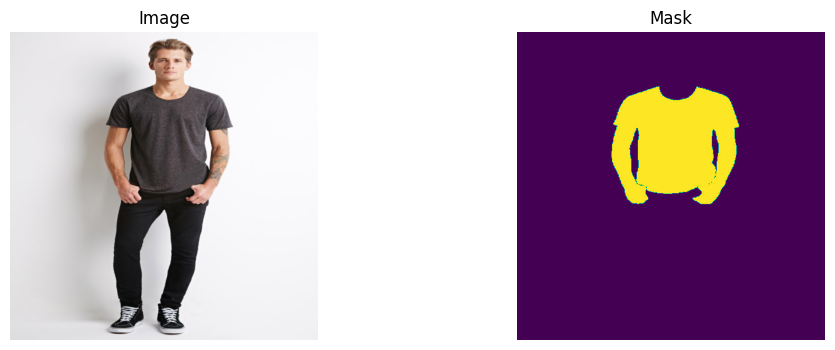

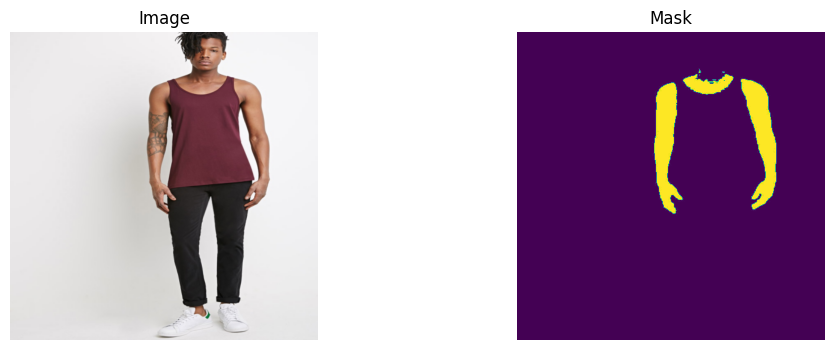

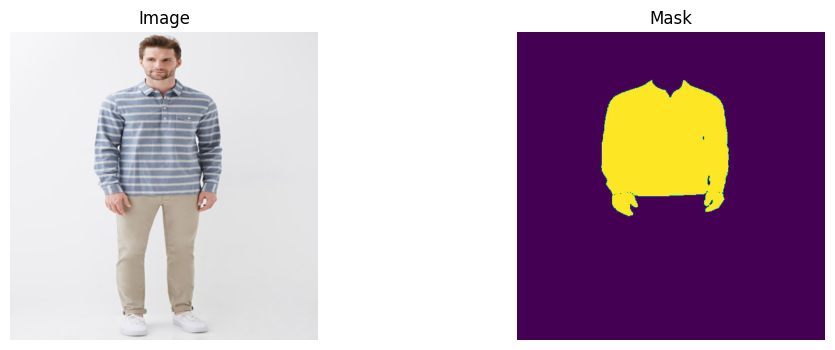

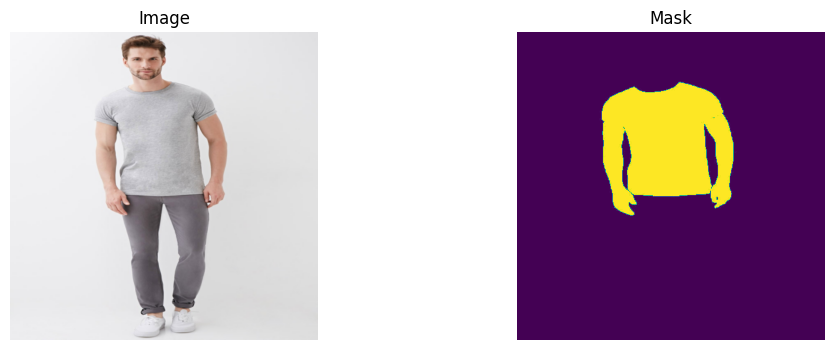

In [53]:
for i, example in enumerate(train_dataset):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    image = example["PIL_image"] #.permute(0, 2, 3, 1)
    mask = example["mask"] #.permute(0, 2, 3, 1)

    axs[0].imshow(image)
    axs[0].set_title('Image')
    axs[0].axis('off')

    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    axs[1].axis('off')

    if i == 3:
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


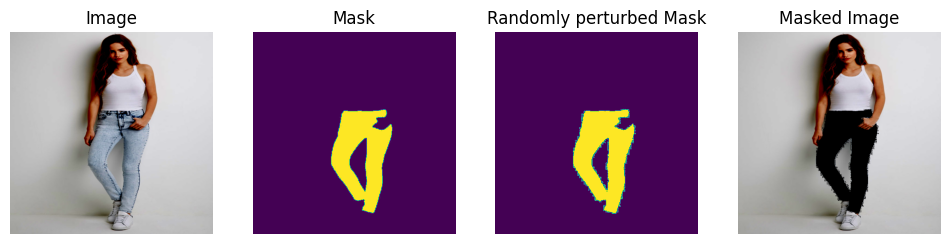

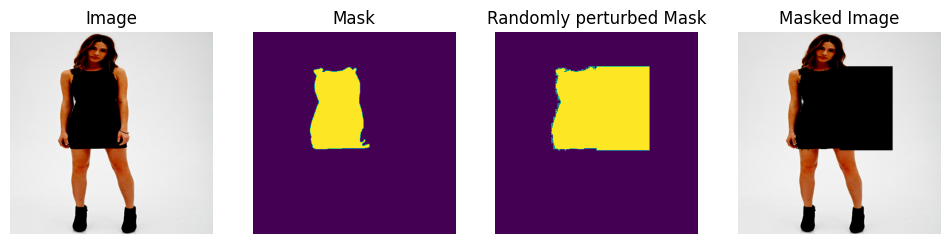

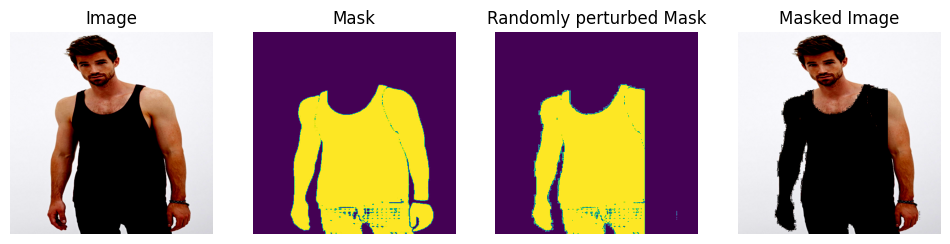

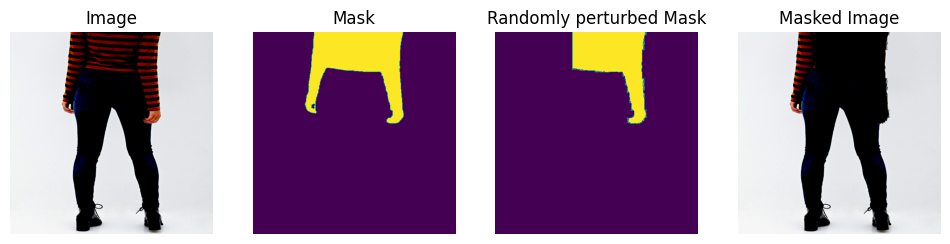

In [55]:
for i, example in enumerate(train_dataloader):
    fig, axs = plt.subplots(1, 4, figsize=(12, 4))
    masked_image = example["masked_images"].permute(0, 2, 3, 1)
    image = example["pixel_values"].permute(0, 2, 3, 1)
    mask = example["masks"].permute(0, 2, 3, 1)
    mask_og = example["masks_og"]

    axs[0].imshow(image[0].numpy())
    axs[0].set_title('Image')
    axs[0].axis('off')

    axs[1].imshow(mask_og[0])
    axs[1].set_title('Mask')
    axs[1].axis('off')

    axs[2].imshow(mask[0])
    axs[2].set_title('Randomly perturbed Mask')
    axs[2].axis('off')

    axs[3].imshow(masked_image[0])
    axs[3].set_title('Masked Image')
    axs[3].axis('off')
    if i == 3:
        break

# Targetted Mask Generation with prior preservation data

In [ ]:
import os
from PIL import Image, ImageDraw
import numpy as np
import torch
import json
import random
from glob import glob
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import transforms
from transformers import CLIPTokenizer

In [ ]:
def prepare_mask_and_masked_image(image, mask):
    image = np.array(image.convert("RGB"))
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image).to(dtype=torch.float32) / 127.5 - 1.0

    mask = np.array(mask.convert("L"))
    mask = mask.astype(np.float32) / 255.0
    mask = mask[None, None]
    mask[mask < 0.5] = 0
    mask[mask >= 0.5] = 1
    mask = torch.from_numpy(mask)

    masked_image = image * (mask < 0.5)

    return mask, masked_image


# generate random masks
def random_mask(im_shape, ratio=1, mask_full_image=False):
    mask = Image.new("L", im_shape, 0)
    draw = ImageDraw.Draw(mask)
    size = (random.randint(0, int(im_shape[0] * ratio)), random.randint(0, int(im_shape[1] * ratio)))
    # use this to always mask the whole image
    if mask_full_image:
        size = (int(im_shape[0] * ratio), int(im_shape[1] * ratio))
    limits = (im_shape[0] - size[0] // 2, im_shape[1] - size[1] // 2)
    center = (random.randint(size[0] // 2, limits[0]), random.randint(size[1] // 2, limits[1]))
    draw_type = random.randint(0, 1)
    if draw_type == 0 or mask_full_image:
        draw.rectangle(
            (center[0] - size[0] // 2, center[1] - size[1] // 2, center[0] + size[0] // 2, center[1] + size[1] // 2),
            fill=255,
        )
    else:
        draw.ellipse(
            (center[0] - size[0] // 2, center[1] - size[1] // 2, center[0] + size[0] // 2, center[1] + size[1] // 2),
            fill=255,
        )

    return mask


class TargetedMaskingDatasetWithPriorPreservation(Dataset):
    def __init__(self, 
                instance_image_captions_file, 
                instance_image_dir,
                instance_images_mask_dir, 
                class_images_dir,
                class_image_captions_file,
                tokenizer,
                image_size=512):
        self.tokenizer = tokenizer
        self.instance_image_captions = self.caption_file_reader(instance_image_captions_file)
        self.mask_directory = instance_images_mask_dir
        self.instance_image_list = [os.path.join(instance_image_dir, image_file) for image_file in self.instance_image_captions.keys()]
        self.class_image_captions = self.caption_file_reader(class_image_captions_file)
        self.class_image_list = [os.path.join(class_images_dir, image_file) for image_file in self.class_image_captions.keys()]
        if len(self.class_image_list) > len(self.instance_image_list):
            self.class_image_list = random.sample(self.class_image_list, len(self.instance_image_list) - 1)
        elif len(self.class_image_list) < len(self.instance_image_list):
            required_samples_count = len(self.instance_image_list) - len(self.class_image_list)
            while required_samples_count > 0:
                if required_samples_count > len(self.class_image_list):
                    class_image_list = random.sample(self.class_image_list, len(self.class_image_list) - 1)
                    required_samples_count -= (len(self.class_image_list) - 1)
                else:
                    class_image_list = random.sample(self.class_image_list, required_samples_count)
                    required_samples_count = 0
                self.class_image_list.extend(class_image_list)
    
        self.image_transforms_resize_and_crop = transforms.Compose(
            [
                transforms.Resize(image_size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.RandomCrop(image_size),
            ]
        )
        
        self.image_transforms_resize = transforms.Compose(
            [
                transforms.Resize((image_size, image_size), interpolation=transforms.InterpolationMode.BILINEAR),
                # transforms.CenterCrop(image_size)
            ]
        )
        self.image_transforms_resize2 = transforms.Compose(
            [
                transforms.Resize((image_size, image_size), interpolation=transforms.InterpolationMode.NEAREST),
                # transforms.CenterCrop(image_size)
            ]
        )
        self.image_transforms = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return len(self.instance_image_captions)

    @staticmethod
    def caption_file_reader(captions_file_path, image_directory=None):
        ext = os.path.splitext(captions_file_path)[1]
        if captions_file_path.endswith(".txt"):
            assert image_directory is not None
            captions = text_file_reader(captions_file_path)
            image_vs_captions = dict()
            img_list = glob(os.path.join(image_directory, '*.jpg'))
            for img_path, caption in zip(img_list, captions):
                img_name = os.path.basename(img_path)
                image_vs_captions[img_name] = caption
            return image_vs_captions
        elif captions_file_path.endswith(".json"):
            """
            Code for creating a dictionary of image_name vs captions by reading a json file 
            """
            with open(captions_file_path, "r") as json_file:
                image_vs_captions = json.load(json_file)
            return image_vs_captions

        elif captions_file_path.endswith(".yaml"):
            """
            Code for creating a dictionary of image_name vs captions by reading a yaml file 
            """
            pass
        elif captions_file_path.endswith(".token"):
            with open(captions_file_path, 'r', encoding='utf-8') as file:
                content = file.readlines()
            image_vs_caption = dict()
            for line in content:
                image_name, caption = line.split("\n")[0].split("\t")
                image_name = image_name.split("#")[0]
                if image_vs_caption.get(image_name):
                    continue
                image_vs_caption[image_name] = caption
            return image_vs_caption
    
    def __getitem__(self, idx):
        example = dict()
        image_name = os.path.basename(self.instance_image_list[idx])
        instance_image = Image.open(self.instance_image_list[idx])
        mask_paths = os.listdir(os.path.join(self.mask_directory, image_name.split(".")[0]))
        if not instance_image.mode == "RGB":
            instance_image = instance_image.convert("RGB")
        random_selector = np.random.randint(0, len(mask_paths))
        # print(mask_paths[random_selector])
        selected_mask = Image.open(os.path.join(self.mask_directory, os.path.join(image_name.split(".jpg")[0], mask_paths[random_selector])))
        example["mask"] = self.image_transforms_resize2(selected_mask)
        instance_image = self.image_transforms_resize(instance_image)
        example["PIL_image"] = instance_image
        example["instance_image"] = self.image_transforms(instance_image)
        example["instance_prompt_ids"] = self.tokenizer(
            self.instance_image_captions[image_name],
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids
        class_image_name = os.path.basename(self.class_image_list[idx])
        class_image = Image.open(self.class_image_list[idx])
        if not class_image.mode == "RGB":
                class_image = class_image.convert("RGB")
        class_image = self.image_transforms_resize_and_crop(class_image)
        example["class_images"] = self.image_transforms(class_image)
        example["class_PIL_images"] = class_image
        example["class_prompt_ids"] = self.tokenizer(
            self.class_image_captions[class_image_name],
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids
        return example


def random_perturb_mask(mask):
    ones = np.where(mask > 0)
    mask[mask > 0] = 1
    y_max, y_min, x_max, x_min = max(ones[0]), min(ones[0]), max(ones[1]), min(ones[1])
    increase_or_decrease = [0, 1]
    up_down_left_right = [0, 1, 2, 3]
    choice_increase_or_decrease = np.random.choice(increase_or_decrease)
    choice_udlr = np.random.choice(up_down_left_right)
    if choice_udlr == 0 or choice_udlr == 1:
        increase_or_decrease_quantity = np.random.randint(50, 100)
    elif choice_udlr == 2 or choice_udlr == 3:
        increase_or_decrease_quantity = np.random.randint(50, 100)
    # print(choice_increase_or_decrease, choice_udlr, increase_or_decrease_quantity)
    if choice_increase_or_decrease == 0:
        if choice_udlr == 0:
            increase_or_decrease_quantity = min(increase_or_decrease_quantity, y_min)
            mask[y_min - increase_or_decrease_quantity: y_min + (y_max - y_min) // 6, x_min: x_max + 1] = True
        elif choice_udlr == 1:
            increase_or_decrease_quantity = min(increase_or_decrease_quantity, mask.shape[0] - y_max)
            mask[y_max - (y_max - y_min) // 6: y_max + increase_or_decrease_quantity, x_min: x_max + 1] = True
        elif choice_udlr == 2:
            increase_or_decrease_quantity = min(x_min, increase_or_decrease_quantity)
            mask[y_min: y_max + 1, x_min - increase_or_decrease_quantity: x_min + (x_max - x_min) // 4] = True
        else:
            increase_or_decrease_quantity = min(mask.shape[1] - x_max, increase_or_decrease_quantity)
            mask[y_min: y_max + 1, x_max - (x_max - x_min) // 4: x_max + increase_or_decrease_quantity] = True
    elif choice_increase_or_decrease == 1:
        if choice_udlr == 0:
            mask[y_min: y_min + increase_or_decrease_quantity, x_min: x_max + 1] = False
        elif choice_udlr == 1:
            mask[y_max: y_max - increase_or_decrease_quantity, x_min: x_max + 1] = False
        elif choice_udlr == 2:
            mask[y_min: y_max + 1, x_min: x_min + increase_or_decrease_quantity] = False
        else:
            mask[y_min: y_max + 1, x_max - increase_or_decrease_quantity: x_max] = False
    return mask


def collate_fn(examples):
    input_ids = [example["instance_prompt_ids"] for example in examples]
    pixel_values = [example["instance_image"] for example in examples]
    input_ids += [example["class_prompt_ids"] for example in examples]
    pixel_values += [example["class_images"] for example in examples]
    pior_pil = [example["class_PIL_images"] for example in examples]
    masks = []
    masked_images = []
    for example in examples:
        pil_image = np.array(example["PIL_image"])
        mask = np.array(example["mask"])
        mask = random_perturb_mask(mask)
        image = torch.from_numpy(pil_image).to(dtype=torch.float32) / 127.5 - 1.0
        mask = torch.from_numpy(mask)
        mask = mask.unsqueeze(2)
        masked_image = image * (mask.expand(-1, -1, 3) == 0)
        masked_image = masked_image.permute(2, 0, 1)
        mask = mask.permute(2, 0, 1)
        masks.append(mask)
        masked_images.append(masked_image)
    
    for pil_image in pior_pil:
        # generate a random mask
        mask = random_mask(pil_image.size, 1, False)
        # prepare mask and masked image
        mask, masked_image = prepare_mask_and_masked_image(pil_image, mask)

        masks.append(mask[0])
        masked_images.append(masked_image[0])

    pixel_values = torch.stack(pixel_values)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
    input_ids = tokenizer.pad({"input_ids": input_ids}, padding=True, return_tensors="pt").input_ids
    masks = torch.stack(masks)
    masked_images = torch.stack(masked_images)
    batch = {"input_ids": input_ids, "pixel_values": pixel_values, "masks": masks, "masked_images": masked_images}
    return batch

In [ ]:
tokenizer = CLIPTokenizer.from_pretrained("stabilityai/stable-diffusion-2-inpainting", subfolder="tokenizer")

In [ ]:
train_dataset = TargetedMaskingDatasetWithPriorPreservation(
                                                            instance_image_captions_file=r"C:\Users\sumuk\OneDrive\Desktop\GitHub\FashionXchange\mask_generation\masked_image_captions.json", 
                                                            instance_image_dir=r"C:\Users\sumuk\OneDrive\Desktop\GitHub\FashionXchange\images",
                                                            instance_images_mask_dir=r"C:\Users\sumuk\OneDrive\Desktop\GitHub\FashionXchange\mask_generation\Masks", 
                                                            class_images_dir=r"C:\Users\sumuk\OneDrive\Desktop\GitHub\FashionXchange\Flickr30k\flickr30k-images",
                                                            class_image_captions_file=r"C:\Users\sumuk\OneDrive\Desktop\GitHub\FashionXchange\Flickr30k\results_20130124.token",
                                                            tokenizer=tokenizer,
                                                            image_size=512
                                                            )

In [ ]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn
)

In [ ]:
for i, example in enumerate(train_dataloader):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    masked_image = example["masked_images"].permute(0, 2, 3, 1)
    image = example["pixel_values"].permute(0, 2, 3, 1)
    mask = example["masks"].permute(0, 2, 3, 1)
    # print(example.keys())
    # axs[2].imshow(image[0].numpy())
    # axs[2].set_title('Image')
    # axs[2].axis('off')
    axs[1].imshow(masked_image[1])
    axs[1].set_title('Masked Class Image')
    axs[1].axis('off')
    axs[0].imshow(masked_image[0])
    axs[0].set_title('Masked Instance Image')
    axs[0].axis('off')
    # if i == 3:
    print(np.unique(mask[0], return_counts=True))
    break

In [ ]:
captions_file_path = r"C:\Users\sumuk\OneDrive\Desktop\GitHub\FashionXchange\Flickr30k\results_20130124.token"
with open(captions_file_path, 'r') as file:
    content = file.readlines()
image_vs_caption = dict()
for line in content:
    image_name, caption = line.split("\n")[0].split("\t")
    image_name = image_name.split("#")[0]
    if image_vs_caption.get(image_name):
        continue
    image_vs_caption[image_name] = caption

# Final pipeline

In [ ]:
import sys
sys.path.append(r"C:\Users\sumuk\OneDrive\Desktop\GitHub\FashionXchange")

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import argparse
import groundingdino.datasets.transforms as T
from PIL import Image
from torchvision.ops import box_convert
from matplotlib import patches 
from segment_anything import SamPredictor, sam_model_registry
from diffusers import StableDiffusionInpaintPipeline
from groundingdino.util.inference import load_model, load_image, predict, annotate
from GroundingDINO.groundingdino.util import box_ops


In [ ]:
device = "cpu"
groundingdino_model_path = r"C:\Users\sumuk\OneDrive\Desktop\GitHub\FashionXchange\GroundingDINO\groundingdino\config\GroundingDINO_SwinT_OGC.py"
groundingdino_weights_path = r"C:\Users\sumuk\OneDrive\Desktop\GitHub\FashionXchange\GroundingDINO\weights\groundingdino_swint_ogc.pth"
groundingdino_model = load_model(groundingdino_model_path, groundingdino_weights_path)

In [ ]:
sam_checkpoint_path = r"C:\Users\sumuk\OneDrive\Desktop\GitHub\FashionXchange\GroundingDINO\weights\sam_vit_b_01ec64.pth"
model_type = "vit_b"
sam_model = sam_model_registry[model_type](checkpoint=sam_checkpoint_path).to(device=device)
sam_predictor = SamPredictor(sam_model)

In [ ]:
pipeline = StableDiffusionInpaintPipeline.from_pretrained(r"C:\Users\sumuk\OneDrive\Desktop\GitHub\FashionXchange\checkpoint-82752").to(device)

In [ ]:
image_path = r"C:\Users\sumuk\OneDrive\Desktop\GitHub\FashionXchange\me_ootb.jpg"

In [ ]:
def dino_person_prediction(image_path):
    src, img = load_image(image_path)
    boxes_og, logits, phrases = predict(
        model=groundingdino_model,
        image=img,
        caption="person",
        box_threshold=0.3,
        text_threshold=0.25,
        device=device
    )
    return src, boxes_og, logits, phrases


def find_person_in_image(src, boxes_og):
    h, w, _ = src.shape
    boxes = (boxes_og * torch.Tensor([w, h, w, h])).to(torch.int16)
    boxes = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()
    boxes = np.array(boxes, dtype=np.int16)
    # print(person_boxes, shirt)
    if len(boxes) > 1:
        person, selected_id = get_person_choice(src, boxes)
        box = boxes[selected_id]
        # box_og = boxes_og[person_boxes[selected_id]]
    else:    
        print(boxes[0])
        box = boxes[0]
        # box_og = boxes_og[person_boxes[0]]
        person = src[box[1]: box[3], box[0]: box[2]]
        print("The outfit change will be made to the following person: ")
        plt.imshow(person)
    return person, box


def get_person_choice(src, boxes):
    fig, axs = plt.subplots((len(boxes) // 3) + 1, 3, figsize=(20, 20))
    people_list = []
    for i in range(len(boxes)):
        column = ((i + 1) % 3) - 1
        row = i // 3
        box = [int(j) for j in boxes[i]]
        person_i = src[box[1]: box[3], box[0]: box[2], :]
        people_list.append(person_i)
        axs[row, column].imshow(person_i, cmap='gray')
        axs[row, column].set_title(f'person_{i}')
    plt.show()
    print("Multiple people found in the image. Please select which person to chose based on the ID: ")
    selected_index = input()
    return people_list[int(selected_index)], int(selected_index)


def get_outfit_in_person(person, attribute):
    person_pil = Image.fromarray(person)
    person_transformed, _ = transform(person_pil, None)
    boxes, logits, phrases = predict(
            model=groundingdino_model,
            image=person_transformed,
            caption=attribute,
            box_threshold=0.3,
            text_threshold=0.25,
            device=device
        )
    return boxes, logits, phrases

# def get_outfit_in_person(person):
#     h, w, _ = src.shape
#     boxes = (boxes_og * torch.Tensor([w, h, w, h])).to(torch.int16)
#     boxes = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()
#     person_boxes = [j for j, _ in enumerate(boxes) if phrases[j] == "person"]
#     shirt = [j for j, _ in enumerate(boxes) if phrases[j] == "clothes"]
#     # print(person_boxes, shirt)
#     if len(person_boxes) > 1:
#         person, selected_id = get_person_choice(src, [boxes[i] for i in person_boxes])
#         box = boxes[person_boxes[selected_id]]
#         # box_og = boxes_og[person_boxes[selected_id]]
#     else:    
#         box = boxes[person_boxes[0]]
#         # box_og = boxes_og[person_boxes[0]]
#         person = src[box[1]: box[3], box[0]: box[2]]
#         print("The outfit change will be made to the following person: ")
#         plt.imshow(person)
#     clothing_box_id = select_required_clothing(box, [boxes[i] for i in shirt])
#     clothing_box = boxes[shirt[clothing_box_id]] 
#     clothing_box[0], clothing_box[1], clothing_box[2], clothing_box[3] = clothing_box[0] - box[0], clothing_box[1] - box[1], clothing_box[2] - box[0], clothing_box[3] - box[1]
#     # box_reformed = [0, person.shape[1], 0, person.shape[0]]
#     return person, clothing_box, src, box


def select_required_clothing(ref_box, boxes):
    ref_box = torch.tensor([ref_box])
    boxes = torch.Tensor(boxes)
    x1 = torch.max(ref_box[:, 0], boxes[:, 0])
    y1 = torch.max(ref_box[:, 1], boxes[:, 1])
    x2 = torch.min(ref_box[:, 0] + ref_box[:, 2], boxes[:, 0] + boxes[:, 2])
    y2 = torch.min(ref_box[:, 1] + ref_box[:, 3], boxes[:, 1] + boxes[:, 3])
    width = torch.clamp(x2 - x1, min=0)
    height = torch.clamp(y2 - y1, min=0)
    intersection_areas = width * height
    return int(torch.argmax(intersection_areas))


def show_mask(mask, image, random_color=True):
    """
    Overlay a mask on an image and return the composited result.

    Args:
        mask (torch.Tensor): Mask to overlay.
        image (np.ndarray): Image to overlay the mask on.
        random_color (bool, optional): If True, overlay with random color.
                                      If False, use a fixed color. Default is True.

    Returns:
        np.ndarray: Image with the mask overlaid.
    """
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])

    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )

def transform_boxes(predictor, boxes, src, device):
    """
    Transform boxes to adjust to the source image dimensions.

    Args:
        boxes (torch.Tensor): Bounding boxes in the format [x_center, y_center, width, height].
        src (np.ndarray): Source image.

    Returns:
        torch.Tensor: Transformed boxes.
    """
    H, W, _ = src.shape
    boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])
    return predictor.transform.apply_boxes_torch(boxes_xyxy, src.shape[:2]).to(device)

In [ ]:
src, boxes_og, logits, phrases = dino_person_prediction(image_path)
all_preds = annotate(src, boxes_og, logits, phrases)
plt.figure(figsize=(10, 10))
plt.imshow(all_preds)

In [ ]:
person, box = find_person_in_image(src, boxes_og)

In [ ]:
attribute_boxes, attribute_logits, attribute_phrases = get_outfit_in_person(person, "clothes, arms, legs")
second_ann = annotate(person, attribute_boxes, attribute_logits, attribute_phrases)
plt.imshow(second_ann)

In [ ]:
# clothing_box = np.asarray(clothing_box, dtype=np.int16)
# box = np.asarray(box, dtype=np.int16)
# plt.imshow(person), box_og, box, clothing_box_og, clothing_box

In [ ]:
# plt.figure(figsize=(10, 10))
# boxes = torch.stack([box_og, clothing_box_og])
# img_ann = annotate(src, boxes, [0.9, 0.9], ["person", "shirt"])
# plt.imshow(img_ann)

In [ ]:
attribute_boxes_tr = transform_boxes(sam_predictor, attribute_boxes, person, device)

In [ ]:
sam_predictor.set_image(person)
masks, _, _ = sam_predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=torch.Tensor(attribute_boxes_tr),
    multimask_output=False,
)
masks = torch.any(masks, dim=0, keepdim=True)
img_annotated_mask = show_mask(
    masks[0][0].cpu(),
    person
)

In [ ]:
plt.imshow(img_annotated_mask)

In [ ]:
change_required = "A man in red hoodie"

In [ ]:
edited_image = pipeline(prompt=change_required,
                        image=Image.fromarray(person).resize((512, 512)),
                        mask_image=Image.fromarray(masks[0][0].numpy()).resize((512, 512))
    ).images[0]

In [ ]:
edited_image = edited_image.resize((person.shape[1], person.shape[0]))
plt.imshow(edited_image)

In [ ]:
src = np.array(src)
box = [int(i) for i in box]
src[box[1]: box[3], box[0]: box[2]] = edited_image
plt.imshow(src)

# Video editing

In [73]:
import sys
sys.path.append(r"C:\Users\sumuk\OneDrive\Desktop\GitHub\FashionXchange")

In [72]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import argparse
import groundingdino.datasets.transforms as T
from PIL import Image
from torchvision import transforms
from torchvision.ops import box_convert
from matplotlib import patches 
from segment_anything import SamPredictor, sam_model_registry
from diffusers import StableDiffusionInpaintPipeline
from groundingdino.util.inference import load_model, load_image, predict, annotate
from GroundingDINO.groundingdino.util import box_ops
from typing import Tuple, List
from groundingdino.util.utils import get_phrases_from_posmap
from groundingdino.util.inference import preprocess_caption


In [74]:
device = "cpu"
groundingdino_model_path = r"C:\Users\sumuk\OneDrive\Desktop\GitHub\FashionXchange\GroundingDINO\groundingdino\config\GroundingDINO_SwinT_OGC.py"
groundingdino_weights_path = r"C:\Users\sumuk\OneDrive\Desktop\GitHub\FashionXchange\GroundingDINO\weights\groundingdino_swint_ogc.pth"
groundingdino_model = load_model(groundingdino_model_path, groundingdino_weights_path)

final text_encoder_type: bert-base-uncased


In [75]:
sam_checkpoint_path = r"C:\Users\sumuk\OneDrive\Desktop\GitHub\FashionXchange\GroundingDINO\weights\sam_vit_b_01ec64.pth"
model_type = "vit_b"
sam_model = sam_model_registry[model_type](checkpoint=sam_checkpoint_path).to(device=device)
sam_predictor = SamPredictor(sam_model)

In [76]:
pipeline = StableDiffusionInpaintPipeline.from_pretrained(r"C:\Users\sumuk\OneDrive\Desktop\GitHub\FashionXchange\checkpoint-82752").to(device)

Loading pipeline components...:  83%|████████▎ | 5/6 [00:05<00:00,  1.04it/s]c:\Users\sumuk\anaconda3\envs\FashionXchange\lib\site-packages\diffusers\utils\outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Loading pipeline components...: 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


In [77]:
def extract_frames(video_path, frame_rate):
    video_capture = cv2.VideoCapture(video_path)

    if not video_capture.isOpened():
        print("Error: Unable to open video file.")
        return

    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )

    # Get the total number of frames and frame rate of the video
    total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    video_fps = video_capture.get(cv2.CAP_PROP_FPS)

    # Calculate frame interval based on the desired frame rate
    frame_interval = int(round(video_fps / frame_rate))

    # Initialize variables
    frame_count = 0
    success = True

    frames = []
    frames_transformed = []

    # Loop through the video frames
    while success:
        # Read a frame
        success, frame = video_capture.read()

        # Check if frame read successfully and if it's time to save based on frame rate
        if success and frame_count % frame_interval == 0:
            # Save the frame as an image
            frame = np.flip(frame, 2)
            frames.append(frame)
            frame_transformed, _ = transform(Image.fromarray(frame), None)
            frames_transformed.append(frame_transformed)

        # Increment frame count
        frame_count += 1

    # Release the video capture object
    video_capture.release()
    return frames, torch.stack(frames_transformed)


# Copied from https://github.com/yuwenmichael/Grounding-DINO-Batch-Inference/blob/main/batch_utlities.py
def predict_batch(
        model,
        images: torch.Tensor,
        caption: str,
        box_threshold: float,
        text_threshold: float,
        device: str = "cuda"
) -> Tuple[List[torch.Tensor], List[torch.Tensor], List[List[str]]]:
    '''
    return: 
        bboxes_batch: list of tensors of shape (n, 4)
        predicts_batch: list of tensors of shape (n,)
        phrases_batch: list of list of strings of shape (n,)
        n is the number of boxes in one image
    '''
    caption = preprocess_caption(caption=caption)
    model = model.to(device)
    image = images.to(device)
    with torch.no_grad():
        outputs = model(image, captions=[caption for _ in range(len(images))]) # <------- I use the same caption for all the images for my use-case
    prediction_logits = outputs["pred_logits"].cpu().sigmoid()  # prediction_logits.shape = (num_batch, nq, 256)
    prediction_boxes = outputs["pred_boxes"].cpu()  # prediction_boxes.shape = (num_batch, nq, 4)

    # import ipdb; ipdb.set_trace()
    mask = prediction_logits.max(dim=2)[0] > box_threshold # mask: torch.Size([num_batch, 256])
    
    bboxes_batch = []
    predicts_batch = []
    phrases_batch = [] # list of lists
    tokenizer = model.tokenizer
    tokenized = tokenizer(caption)
    for i in range(prediction_logits.shape[0]):
        logits = prediction_logits[i][mask[i]]  # logits.shape = (n, 256)
        phrases = [
                    get_phrases_from_posmap(logit > text_threshold, tokenized, tokenizer).replace('.', '')
                    for logit # logit is a tensor of shape (256,) torch.Size([256])
                    in logits # torch.Size([7, 256])
                  ]
        boxes = prediction_boxes[i][mask[i]]  # boxes.shape = (n, 4)
        phrases_batch.append(phrases)
        bboxes_batch.append(boxes)
        predicts_batch.append(logits.max(dim=1)[0])
    
    return bboxes_batch, predicts_batch, phrases_batch


def dino_outfit_prediction(images):
    boxes_og, _, _ = predict_batch(
        model=groundingdino_model,
        images=images,
        caption="clothes, arms, legs",
        box_threshold=0.3,
        text_threshold=0.25,
        device=device
    )
    return boxes_og


def transform_boxes(predictor, boxes, src, device):
    """
    Transform boxes to adjust to the source image dimensions.

    Args:
        boxes (torch.Tensor): Bounding boxes in the format [x_center, y_center, width, height].
        src (np.ndarray): Source image.

    Returns:
        torch.Tensor: Transformed boxes.
    """
    H, W, _ = src.shape
    
    boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])
    return predictor.transform.apply_boxes_torch(boxes_xyxy, src.shape[:2]).to(device)

def show_mask(mask, image, random_color=True):
    """
    Overlay a mask on an image and return the composited result.

    Args:
        mask (torch.Tensor): Mask to overlay.
        image (np.ndarray): Image to overlay the mask on.
        random_color (bool, optional): If True, overlay with random color.
                                      If False, use a fixed color. Default is True.

    Returns:
        np.ndarray: Image with the mask overlaid.
    """
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])

    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )


def images_to_video(image_list, output_video_path, frame_rate, image_size):
    # Get dimensions of the first image
    first_image = np.array(image_list[0])
    height, width, _ = first_image.shape

    # Initialize video writer object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Define codec
    video_writer = cv2.VideoWriter(output_video_path, fourcc, frame_rate, image_size) #(width, height))

    # Write each image to video
    for frame in image_list:
        frame = frame.resize(image_size)
        frame = np.array(frame)
        video_writer.write(np.flip(frame, 2))

    # Release video writer object
    video_writer.release()

In [78]:
frame_rate = 1

In [79]:
video_path = r"C:\Users\sumuk\OneDrive\Desktop\GitHub\FashionXchange\sample_video.mp4"
video_frames, video_frames_transformed = extract_frames(video_path, frame_rate=frame_rate)
len(video_frames)

3

In [84]:
image_size = Image.fromarray(video_frames[0]).size

In [86]:
attribute_boxes = dino_outfit_prediction(video_frames_transformed)

c:\Users\sumuk\anaconda3\envs\FashionXchange\lib\site-packages\transformers\modeling_utils.py:995: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
c:\Users\sumuk\anaconda3\envs\FashionXchange\lib\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
c:\Users\sumuk\anaconda3\envs\FashionXchange\lib\site-packages\torch\utils\checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


In [87]:
frame_masks = []
for video_frame, bboxes in zip(video_frames, attribute_boxes):
    attribute_boxes_tr = transform_boxes(sam_predictor, bboxes, video_frame, "cpu")
    sam_predictor.set_image(video_frame)
    masks, _, _ = sam_predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=torch.Tensor(attribute_boxes_tr),
        multimask_output=False,
    )
    masks = torch.any(masks, dim=0, keepdim=True)
    frame_masks.append(masks)    

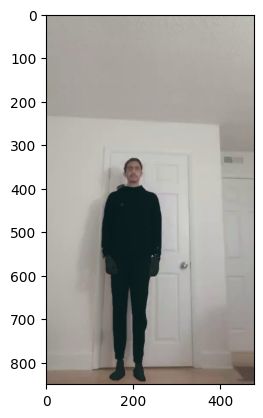

In [88]:
img_annotated_mask = show_mask(
    frame_masks[0][0][0].cpu(),
    video_frames[0]
)
plt.imshow(img_annotated_mask)

In [89]:
changes_required = ["A man in a superman costume", "A man in a spiderman costume", "A man in a batman costume"]

In [91]:
edited_images = []
for image, change_required, masks in zip(video_frames, changes_required, frame_masks):
    edited_image = pipeline(prompt=change_required,
                            image=Image.fromarray(image).resize((512, 512)),
                            mask_image=Image.fromarray(masks[0][0].numpy()).resize((512, 512)),
                            num_inference_steps=10
        ).images[0]
    edited_images.append(edited_image)

100%|██████████| 10/10 [01:04<00:00,  6.50s/it]


In [92]:
output_path = r"C:\Users\sumuk\OneDrive\Desktop\GitHub\FashionXchange\mod_sample_video.mp4"
images_to_video(edited_images, output_path, frame_rate, image_size)